# Understanding sources of variation in single-cell data with GloScope

What explains differences between samples in your data? A disease condition of patients or maybe batch effects? In this tutorial, we will use `patpy` to build a sample representation from single-cell transcriptomics data and evaluate the sources of variation in it.

We will use GloScope, a density-based sample representation method. It treats samples as point clouds, where each point is a cell. To understand how dissimilar samples are, GloScope computes divergence between these point clouds. Intuitively, if some cells states are present in every sample, they will have a little contribution to differences between samples. On the other hand, **sample-specific cell states will have a high contribution**. You can find more details about GloScope in the [original publication](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-024-03398-1).

<img src="images/gloscope_illustration.png" width="400">


Gloscope has shown the best performance among methods in the [SPARE sample representation benchmark](https://openreview.net/forum?id=IoRv5afWtb). It captures clinical information well and uncovers disease trajectories as demonstrated in our [patient trajectory analysis tutorial](https://patpy.readthedocs.io/en/latest/notebooks/Patient_trajectories_example.html). In this notebook, we'll run our Python reimplementation of GloScope. We'll see that it gives identical results to the [original R implemetation](https://www.bioconductor.org/packages/release/bioc/html/GloScope.html), but is orders of magnitude faster.

## 1. Setup

There are 2 possible ways to run GloScope in python: with GPU and without. While both are more efficient than R version, GPU uses accelerated engine for mathematical operations and performs particularly rapidly. But all good things come at a cost: to use GPU you must have it in your computer and install additional packages. If this works for you, follow the installation steps below. **For running CPU version, jump to step 1.3**, all the required dependencies already come with `patpy`.

### 1.1 Option 1 (with conda)

1. Download the environment file from [here](https://github.com/HCA-integration/scAtlasTb/blob/main/envs/rapids_singlecell.yaml) or manually create a file `rapids_singlecell.yaml` with the following content:

```yaml
name: rapids_singlecell
channels:
  - rapidsai
  - nvidia
  - conda-forge
  - bioconda
dependencies:
  - python=3.11
  - anndata=0.11
  - scanpy=1.11
  - leidenalg
  - louvain
  - zarr
  - cuda-version=12
  - rapids=24.06
  - scikit-learn<1.6 # required by dask-ml
  - scipy<1.15
  - dask
  - dask-ml
  - sparse
  - harmonypy
  - pytorch
  - pip
  - pip:
    - rapids-singlecell
    - scikit-learn<1.6
```

2. Create a new conda environment based on this file:

```bash
conda env create -f rapids_singlecell.yaml
```

3. Activate the environment:

```bash
conda activate rapids_singlecell
```

4. Install ipykernel to be able to use this environment in a jupyter notebook:

```bash
conda install ipykernel
```

### 1.2 Option 2 (conda-free). Install the RAPIDS package

You can use the script provided by rapidsai developers. Activate a desired environment, and run the following:

```bash
git clone https://github.com/rapidsai/rapidsai-csp-utils.git
python rapidsai-csp-utils/colab/pip-install.py
```

Run this cell to enable consistent usage of array API:

In [1]:
import os
os.environ["SCIPY_ARRAY_API"] = "1"

### 1.3 Install the patpy package

For latest released version, simply run:

```bash
pip install patpy
```

To get a newer development version (might be unstable), install from github:

```bash
pip install git+https://github.com/lueckenlab/patpy.git@main
```

### 1.4 Import packages

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import patpy
import seaborn as sns
import matplotlib.pyplot as plt

import random

random.seed(42)
np.random.seed(42)

/home/icb/vladimir.shitov/software/miniconda3/envs/rapids_singlecell/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [3]:
patpy.__version__

'0.11.2'

## 2. Data Preparation

### 2.1 Read the data

Here, we use [COMBAT dataset](https://cellxgene.cziscience.com/collections/8f126edf-5405-4731-8374-b5ce11f53e82). This dataset contains 783k cells (after some additional preprocessing) from 138 COVID-19 patients and healthy donors.

In [4]:
ADATA_PATH = "/home/icb/vladimir.shitov/projects/vladimir.shitov/2023_05_patient_representation_benchmark/reproducibility/pat_rep_benchmark/data/combat/combat_processed.h5ad"

In [5]:
adata = sc.read_h5ad(ADATA_PATH)
adata

AnnData object with n_obs × n_vars = 783677 × 3000
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc_HC

### 2.2 Set columns containing sample IDs, cell types and metadata

For convenience, let's store columns contatining patient-level information to python variables:

In [6]:
sample_id_col = "scRNASeq_sample_ID"

# Columns from adata.obs containing metadata about samples
samples_metadata_cols = ["Source", "Outcome", "Death28", "Hospitalstay", "TimeSinceOnset", "Institute", "Pool_ID",
                         "Age", "Sex", "BMI", "PreExistingHeartDisease", "PreExistingLungDisease", "PreExistingDiabetes",
                         "PreExistingHypertension", "Smoking", "Requiredvasoactive", "SARSCoV2PCR"]

# Columns we will use for plotting
cols_to_plot = ["Source", "Outcome", "Death28", "Institute", "Pool_ID"]

Additionally, let's set a layer that we will use as cell representations. It must be `"X"` or one of the keys in either `.layers` or `.obsm`. Here, we will use scVI embedding:

In [7]:
layer = "X_scVI_batch"

### 2.3 Store metadata and calculate QC metrics

To evaluate sample representation, let's extract a sample metadata table from `.obs` data frame in annotated data object:

In [8]:
metadata = adata.obs[samples_metadata_cols + [sample_id_col]].drop_duplicates()
metadata.set_index(sample_id_col, inplace=True)
metadata

,Source,Outcome,Death28,Hospitalstay,TimeSinceOnset,Institute,Pool_ID,Age,Sex,BMI,PreExistingHeartDisease,PreExistingLungDisease,PreExistingDiabetes,PreExistingHypertension,Smoking,Requiredvasoactive,SARSCoV2PCR
scRNASeq_sample_ID,,,,,,,,,,,,,,,,,
S00109-Ja001E-PBCa,COVID_SEV,2.0,0,1.0,12.0,Oxford,gPlexA,5.0,1,5,0.0,0.0,0.0,1.0,0,1.0,1
S00112-Ja003E-PBCa,COVID_MILD,5.0,0,2.0,12.0,Oxford,gPlexA,5.0,1,5,0.0,0.0,0.0,0.0,0,0.0,1
S00005-Ja005E-PBCa,COVID_CRIT,2.0,0,4.0,14.0,Oxford,gPlexA,7.0,0,1,1.0,0.0,0.0,1.0,0,1.0,1
S00061-Ja003E-PBCa,COVID_SEV,4.0,0,2.0,6.0,Oxford,gPlexA,5.0,1,5,0.0,0.0,0.0,0.0,0,0.0,1
S00056-Ja003E-PBCa,COVID_SEV,3.0,0,3.0,23.0,Oxford,gPlexA,7.0,0,5,0.0,0.0,0.0,0.0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S00065-Ja003E-PBCa,COVID_CRIT,2.0,0,3.0,16.0,Oxford,gPlexK,5.0,0,5,0.0,0.0,1.0,0.0,0,1.0,1
S00048-Ja003E-PBCa,COVID_SEV,4.0,0,2.0,12.0,Oxford,gPlexK,7.0,1,3,0.0,0.0,0.0,1.0,0,0.0,1
G05112-Ja005E-PBCa,COVID_HCW_MILD,6.0,0,NaN,7.0,Oxford,gPlexK,4.0,0,5,NaN,NaN,NaN,NaN,0,NaN,1


Let's further add quality control information to evaluate how much representations are affected by number of genes, mRNA counts and percentage of mitochondrial genes. We'll aggregate this cell-level QC metric using a median for every sample:

In [9]:
cell_qc_metadata = patpy.pp.calculate_cell_qc_metrics(
    adata, sample_key=sample_id_col, cell_qc_vars=["QC_ngenes", "QC_total_UMI", "QC_pct_mitochondrial"]
)
cell_qc_metadata.columns = ["median_n_genes_by_counts", "median_total_counts", "median_pct_counts_mt"]
cell_qc_metadata

/ictstr01/groups/luckylab/tools/vladimir.shitov/patient_representation/src/patpy/pp/basic.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  metadata = adata.obs[[sample_key, *cell_qc_vars]].groupby(by=sample_key)
/ictstr01/groups/luckylab/tools/vladimir.shitov/patient_representation/src/patpy/pp/basic.py:180: FutureWarning: The provided callable <function median at 0x7f1257f6a480> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  cells_qc_aggregated = metadata.aggregate(agg_function)


,median_n_genes_by_counts,median_total_counts,median_pct_counts_mt
scRNASeq_sample_ID,,,
G05061-Ja005E-PBCa,1107.0,3125.5,3.011159
G05064-Ja005E-PBCa,975.0,2933.0,1.332430
G05073-Ja005E-PBCa,1141.0,3554.0,2.422559
G05077-Ja005E-PBCa,1125.0,3268.0,2.946723
G05078-Ja005E-PBCa,999.0,3106.0,2.825308
...,...,...,...
U00607-Ua005E-PBUa,1827.0,5749.0,2.982509
U00613-Ua005E-PBUa,1251.5,3325.0,2.053083
U00617-Ua005E-PBUa,1410.5,4524.0,3.886215


In [10]:
n_genes_metadata = patpy.pp.calculate_n_cells_per_sample(adata, sample_id_col)
n_genes_metadata

,n_cells
scRNASeq_sample_ID,
S00052-Ja005E-PBCa,13918
H00054-Ha001E-PBGa,10938
H00067-Ha001E-PBGa,10781
N00023-Ja001E-PBGa,10484
H00053-Ha001E-PBGa,10458
...,...
U00607-Ua005E-PBUa,1021
U00613-Ua005E-PBUa,970
U00701-Ua005E-PBUa,872


Combine all the tables into one:

In [11]:
metadata = pd.concat(
    [
        metadata,
        cell_qc_metadata.loc[metadata.index],
        n_genes_metadata.loc[metadata.index],
    ],
    axis=1,
)

metadata.shape

(138, 21)

Merge aggregated QC to cell metadata:

In [12]:
adata.obs = adata.obs.merge(metadata.drop(columns=samples_metadata_cols), left_on=sample_id_col, right_index=True)

### 2.4 Quality control

To reduce noise in the representations, we need to remove samples with too few cells:

In [13]:
adata = patpy.pp.filter_small_samples(adata, sample_key=sample_id_col, sample_size_threshold=500)

1 samples removed: U00504-Ua005E-PBUa


## 3. Running GloScope in Python

The nearest neighbor computation for the distance matrix calculation can either be done using a CPU or a GPU. By setting the parameter `use_gpu=True` the matrix will be calculated using either [cuML](https://docs.rapids.ai/api/cuml/stable/) or [PyNNDescent](https://pynndescent.readthedocs.io/en/stable/index.html).

### 4.1 Run the GloScope with GPU acceleration

Using patpy, we can run sample representation methods with a simple interface:

In [14]:
gloscope_py = patpy.tl.GloScope_py(sample_key=sample_id_col, layer=layer, k=25, use_gpu=True)
gloscope_py.prepare_anndata(adata)

### 4.2 Calculate the distance matrix between samples

GloScope does not create a vector representation of samples, but instead gives a pairwise KL-divergence matrix. The smaller the values, the more similar samples are. GloScope does not produce "distances" in mathematical sense, but we can treat the divergencies like it. Even with that caveat, it captures more information than other sample representation methods.

In [15]:
%%time
distances_py = gloscope_py.calculate_distance_matrix(force=True)
distances_py

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cuda module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.driver module instead.


CPU times: user 21.4 s, sys: 3.54 s, total: 25 s
Wall time: 2min 14s


array([[0.        , 2.98802018, 4.96645102, ..., 3.36136601, 8.29764793,
        4.77171363],
       [2.98802018, 0.        , 4.58604968, ..., 4.24508584, 7.28937722,
        2.99966394],
       [4.96645102, 4.58604968, 0.        , ..., 5.72771941, 7.25859998,
        3.11516585],
       ...,
       [3.36136601, 4.24508584, 5.72771941, ..., 0.        , 7.92112695,
        5.27670011],
       [8.29764793, 7.28937722, 7.25859998, ..., 7.92112695, 0.        ,
        4.89489186],
       [4.77171363, 2.99966394, 3.11516585, ..., 5.27670011, 4.89489186,
        0.        ]], shape=(137, 137))

Our implementation only takes about two minutes for the whole COMBAT data set when using GPU! Perfect time for you to go for another cup of coffee, but not long enough to make you feel bored.

### 4.3 Visualise the sample representation using UMAP

But does GloScope capture information about samples? Let's build a UMAP plot to get an idea. On this plot, similar patients are localised together:

/home/icb/vladimir.shitov/software/miniconda3/envs/rapids_singlecell/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/icb/vladimir.shitov/software/miniconda3/envs/rapids_singlecell/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/icb/vladimir.shitov/software/miniconda3/envs/rapids_singlecell/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


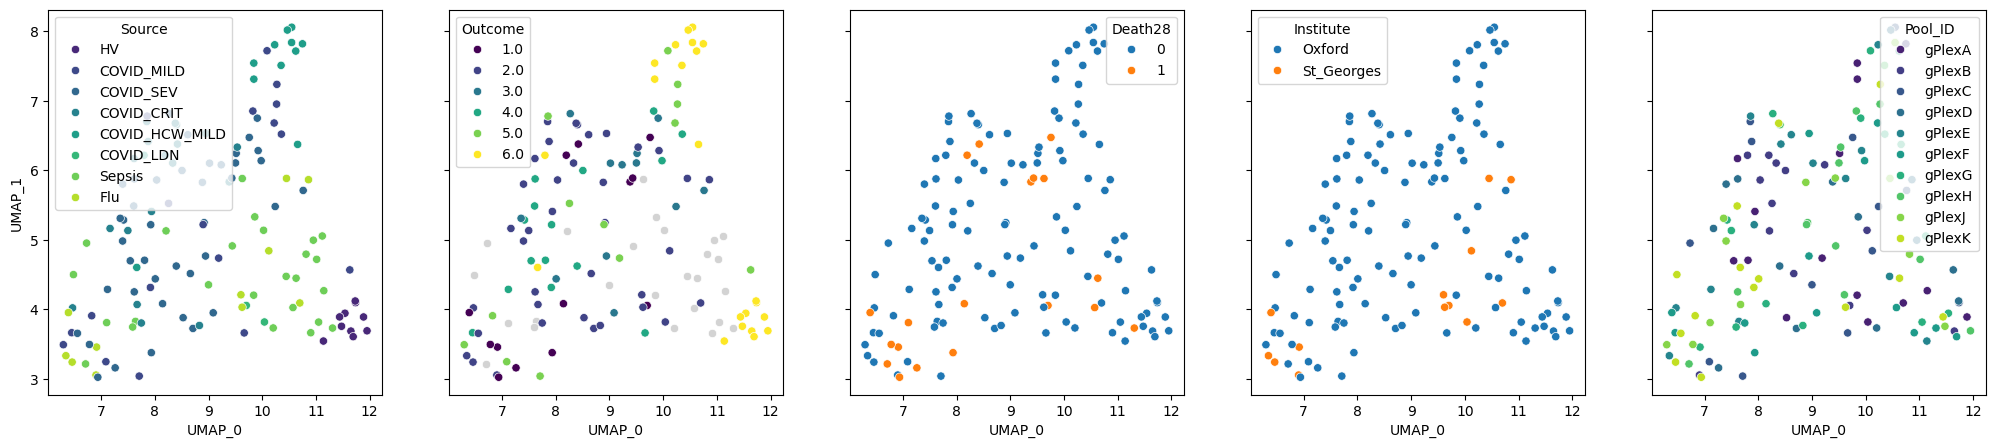

In [16]:
gloscope_py.plot_embedding(method="UMAP", metadata_cols=cols_to_plot);

We can see that patients with similar "Source" and "Outcome" are grouped together. The latter reflects the severity of the disease: from 1, which means death, to 6, which encodes healthy donors. "Death28" column encodes whether patients died in the period of 28 days. The last 2 columns represent locations where samples were processed and the batches. The visualisation suggests that the batches mix with each other and explain the embedding much worse than the Outcome. We will further validate this finding numerically.

## 4. Evaluating sources of variation in the data

While somebody is already writing a wrathful twitter thread on our interpretation of UMAPs, let's compute some metrics to understand what explains sample-level variation in the data. We need to classify our sample-level covariates (columns in the metadata) to clinically relevant, technical and contextual. The former 2 categories can be used to judge whether sample representation method is working well for our analysis goals. The "contextual" category contains columns, which we don't aim to analyse, but may want to know whether they impact the representation.

Furthermore, we need to define prediction tasks for every metadata columns. They must be one of:
- "classification" – for discrete labels such as disease status
- "regression" – for continuous covariates such as number of hospital stay days
- "ranking" – for ranked variables. For example, "Outcome" in our dataset is encoded as numbers from 1 to 6. In this case, if a sample has label "6" (healthy), predicting "5" (hospitalised, no extra oxigen) is better than "3" (non-invasive ventilation).

We will predict each covariate based on the nearest neighbors (the most similar samples) in the representation. Setting the task will define metrics used to evaluate quality of the prediction. For classification, it is F1-macro score (corrected for random prediction), and for other tasks Spearman correlation is used.

In [17]:
benchmark_schema = {
    "relevant": {
        "Source": "classification",
        "Outcome": "ranking",
        "Death28": "classification",
        "Hospitalstay": "regression",
        "TimeSinceOnset": "regression"
    },
    "technical": {
        "Institute": "classification",
        "Pool_ID": "classification",
        "median_n_genes_by_counts": "regression",
        "median_total_counts": "regression",
        "median_pct_counts_mt": "regression",
        "n_cells": "regression"
    },
    "contextual": {
        "Age": "regression",
        "Sex": "classification",
        "BMI": "regression",
        "PreExistingHeartDisease": "classification",
        "PreExistingLungDisease": "classification",
        "PreExistingDiabetes": "classification",
        "PreExistingHypertension": "classification",
        "Smoking": "classification",
        "Requiredvasoactive": "classification",
        "SARSCoV2PCR": "classification"
    }
}

### 4.1 Run the covariate prediction

In [18]:
metadata = metadata.loc[gloscope_py.samples]  # Ensure the order matches the distance matrix

In [19]:
results = []

for type_name, type_data in benchmark_schema.items():
    for target, task in type_data.items():
        result = patpy.tl.evaluate_representation(
            distances=distances_py,
            target=metadata[target],
            method="knn",
            task=task,
            n_neighbors=5
        )

        result["covariate"] = target
        result["covariate_type"] = type_name

        if result["metric"] == "spearman_r":
            result["score"] = abs(result["score"])

        results.append(result)

We can order covariates based on how well they can be predicted from a representation. It gives us an insight on what explains variability in the data:

In [20]:
knn_results = pd.DataFrame(results)
knn_results.sort_values(by="score", ascending=False)

,score,metric,n_unique,n_observations,method,covariate,covariate_type
9,0.745459,spearman_r,137,137,knn,median_pct_counts_mt,technical
7,0.631919,spearman_r,118,137,knn,median_n_genes_by_counts,technical
1,0.626460,spearman_r,6,112,knn,Outcome,relevant
20,0.599415,f1_macro_calibrated,2,137,knn,SARSCoV2PCR,contextual
8,0.585656,spearman_r,131,137,knn,median_total_counts,technical
15,0.549561,f1_macro_calibrated,2,99,knn,PreExistingLungDisease,contextual
4,0.423161,spearman_r,26,127,knn,TimeSinceOnset,relevant
2,0.421534,f1_macro_calibrated,2,137,knn,Death28,relevant
10,0.395705,spearman_r,137,137,knn,n_cells,technical
13,0.317015,spearman_r,6,137,knn,BMI,contextual


### 4.2 Visualise the results

Let's build a plot based on the table above for a nice visual comparision:

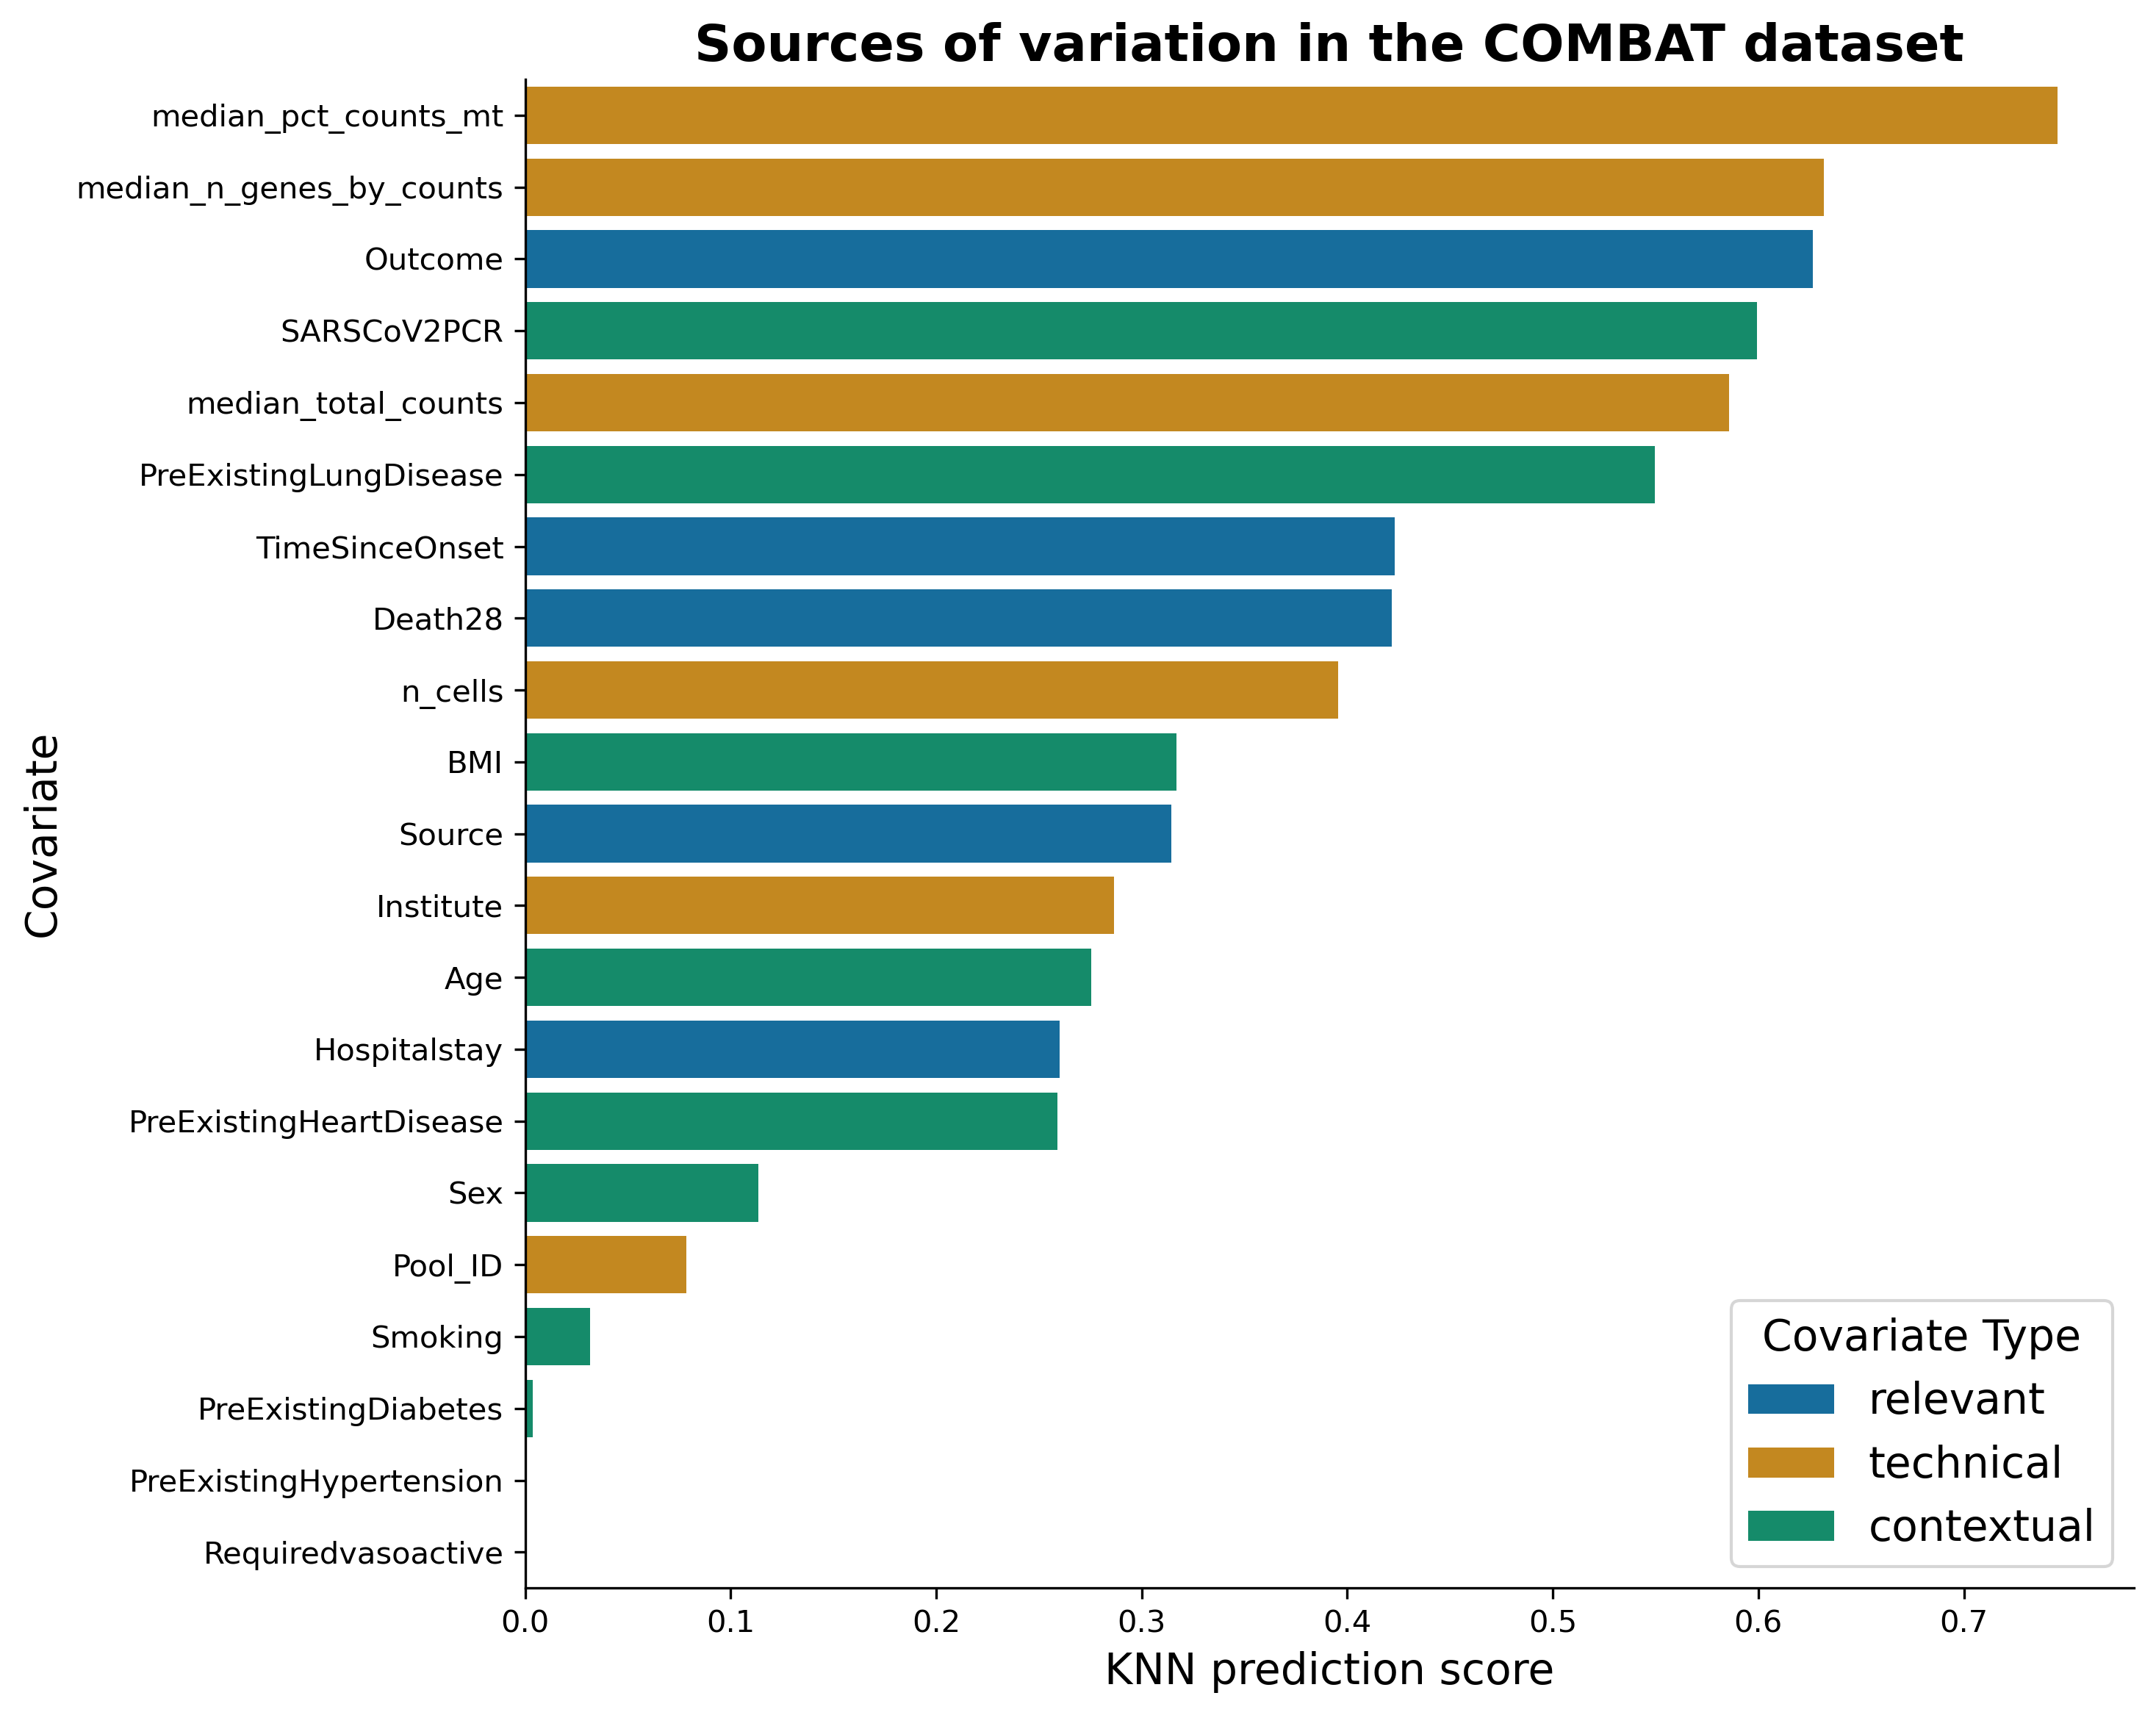

In [21]:
plt.figure(figsize=(10, 8), dpi=300)
plt.rcParams.update({
    'font.size': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

sns.barplot(
    data=knn_results,
    y="covariate",
    x="score",
    hue="covariate_type",
    dodge=False,
    palette="colorblind",
    order=knn_results.sort_values('score', ascending = False).covariate
)

plt.xlabel("KNN prediction score")
plt.ylabel("Covariate")

plt.legend(title="Covariate Type")
plt.title("Sources of variation in the COMBAT dataset", fontweight='bold')

sns.despine()
plt.tight_layout()
plt.show()

We can see that median percentage of mitochondrial counts and median number of genes can be predicted very well from a representation. This is rather bad news, as these covariates are technical. On the bright side, the next best-predicted covariate is the "Outcome", indicating that disease outcome effects the transcriptomics in blood! Let's visualise these covariates on the representation:

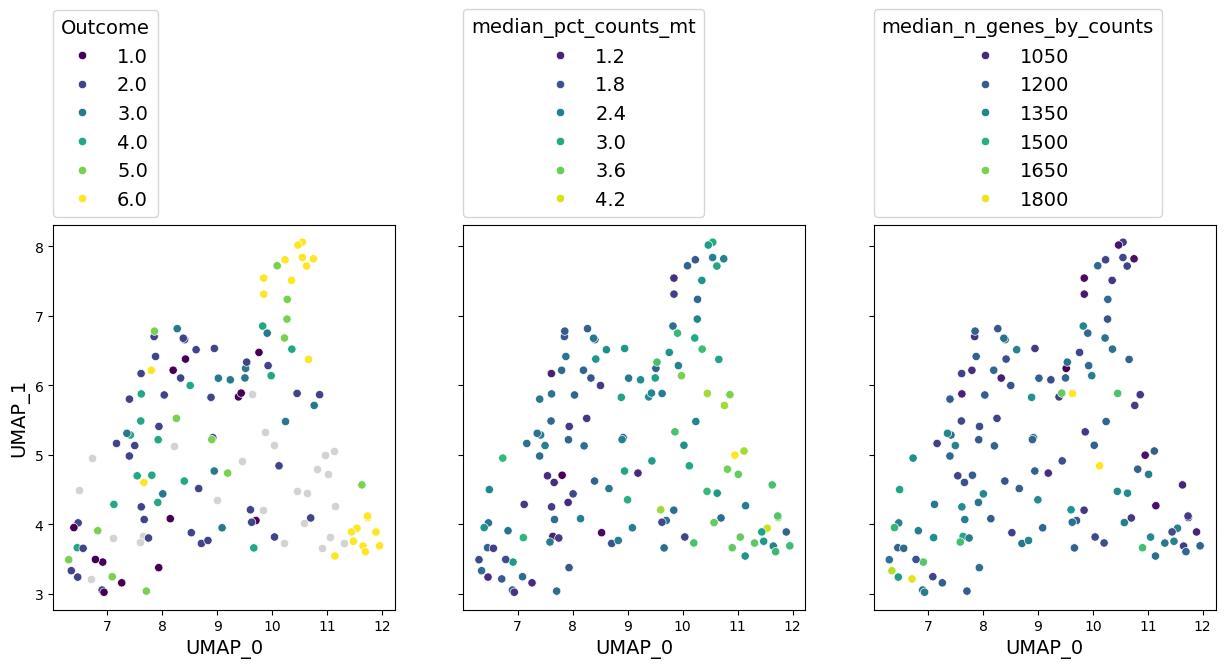

In [22]:
well_represented_cols = ["Outcome", "median_pct_counts_mt", "median_n_genes_by_counts"]

axes = gloscope_py.plot_embedding(method="UMAP", metadata_cols=well_represented_cols)

for ax, col in zip(axes, well_represented_cols):
    ax.legend(loc=(0, 1.02), title=col)

As we previously seen, outcome has a clear grouping on the UMAP. We can also see a notable gradient of median percentage of mitochondrial gene counts and number of genes in a sample.

Another insight we can learn from this sample representation is **what doesn't affect the data**. For example, pre-existing diabetes and hypertension cannot be predicted well from the data we have. That can mean the following:
- These are **not the main axes of variation in the data**. Perhaps, they do affect the transcriptomics, but this effect is hidden behind stronger sources of variation. If you are interested in analysis of those covariates, a more targeted approach is needed.
- **These covariates do not affect the data at all**. There are limitations of what we can predict from transcriptomics. Perhaps, these information is simply beyond them.
- **Metadata is too sparse**. We don't have too many samples with positive values of these covariates. Larger datasets could uncover them better.

In any case, sample representation allows us to immediately see what the data hides.

Note another interesting phenomenon: smoking status can be predicted _worse_ than BMI. Isn't that surprising in the context of respiratory diseases?

### 4.3 Run the GloScope using CPU

If you don't have a GPU, you can still run GloScope in Python way faster than in R! The interface is exactly the same, just set `use_gpu=False` this time:

In [23]:
gloscope_py_cpu = patpy.tl.GloScope_py(sample_key=sample_id_col, layer=layer, k=25, use_gpu=False)
gloscope_py_cpu.prepare_anndata(adata)

In [24]:
%%time
distances_py_cpu = gloscope_py_cpu.calculate_distance_matrix(force=True)
distances_py_cpu

CPU times: user 22min 13s, sys: 5.63 s, total: 22min 19s
Wall time: 22min 9s


array([[0.        , 3.01316958, 4.98487267, ..., 3.3902534 , 8.34240482,
        4.79270835],
       [3.01316958, 0.        , 4.62207723, ..., 4.27903188, 7.35136176,
        3.02328651],
       [4.98487267, 4.62207723, 0.        , ..., 5.754768  , 7.31083296,
        3.14633485],
       ...,
       [3.3902534 , 4.27903188, 5.754768  , ..., 0.        , 7.98588573,
        5.30291834],
       [8.34240482, 7.35136176, 7.31083296, ..., 7.98588573, 0.        ,
        4.93305717],
       [4.79270835, 3.02328651, 3.14633485, ..., 5.30291834, 4.93305717,
        0.        ]], shape=(137, 137))

Well, that took a bit longer than a minute, but still better than 3 hours it takes for the R implementation. You can notice that numbers in the matrix are almost identical to what we had before. Let's take a look at UMAP visualisations:

/home/icb/vladimir.shitov/software/miniconda3/envs/rapids_singlecell/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/icb/vladimir.shitov/software/miniconda3/envs/rapids_singlecell/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


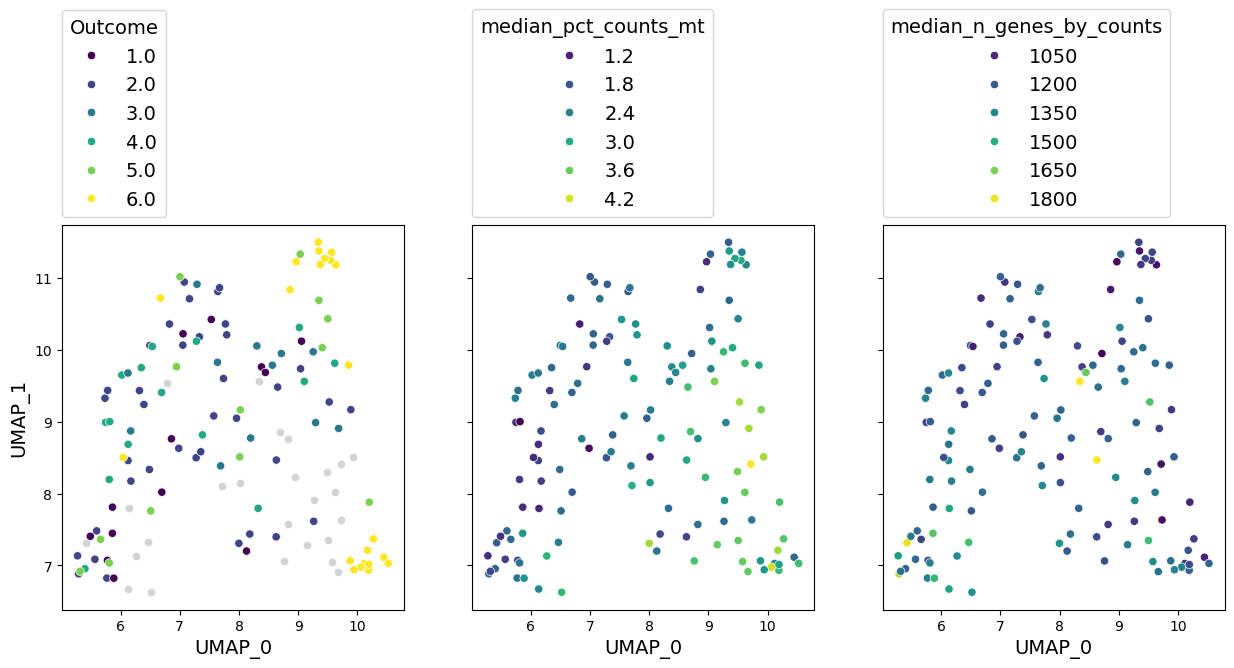

In [25]:
axes = gloscope_py_cpu.plot_embedding(method="UMAP", metadata_cols=well_represented_cols)

for ax, col in zip(axes, well_represented_cols):
    ax.legend(loc=(0, 1.02), title=col)

We can see that embeddings look very similar to what we had before. Qualitative assessment would give the similar results.

## 5. Original GloScope Implementation

This version is [implemented in R](https://www.bioconductor.org/packages/release/bioc/html/GloScope.html) and can be used via patpy. We **do not recommend this approach** for your workflow and only show it here for comparison. 

If you want to run it, you need to install R dependencies. The easiest way to do it is via conda. You can use the following environment:

```yaml
name: gloscope
channels:
  - conda-forge
  - bioconda
dependencies:
  - r-base=4.3
  - r-data.table
  - r-reticulate
  - r-anndata
  - bioconductor-gloscope
  - anndata2ri
```

Or install the required dependencies into an existing environment (don't forget to activate it in prior):
```
conda install -c conda-forge -c bioconda r-base=4.3 r-data.table r-reticulate r-anndata bioconductor-gloscope anndata2ri -y
```

Initialise the sample represenation method. You can set `n_workers` to the number of CPUs on your machine to make the computation faster:

In [26]:
gloscope_r = patpy.tl.GloScope(sample_key=sample_id_col, layer=layer, k=25, n_workers=6)
gloscope_r.prepare_anndata(adata)

In [27]:
%%time
distances_r = gloscope_r.calculate_distance_matrix(force=True)
distances_r

/ictstr01/groups/luckylab/tools/vladimir.shitov/patient_representation/src/patpy/tl/sample_representation.py:453: UserWarning: Using data from key X_scVI_batch of adata.obsm
  warnings.warn(f"Using data from key {self.layer} of adata.obsm", stacklevel=1)


Calculating GloScope distance matrix


CPU times: user 32.2 s, sys: 4.59 s, total: 36.8 s
Wall time: 7h 50min 4s


array([[0.        , 2.88381577, 4.86649874, ..., 3.25397249, 8.19277845,
        4.66033323],
       [2.88381577, 0.        , 4.48540625, ..., 4.13700121, 7.18381653,
        2.88759288],
       [4.86649874, 4.48540625, 0.        , ..., 5.62388687, 7.15729136,
        3.00734636],
       ...,
       [3.25397249, 4.13700121, 5.62388687, ..., 0.        , 7.81237691,
        5.16143919],
       [8.19277845, 7.18381653, 7.15729136, ..., 7.81237691, 0.        ,
        4.78215528],
       [4.66033323, 2.88759288, 3.00734636, ..., 5.16143919, 4.78215528,
        0.        ]], shape=(137, 137))

This implementation of GloScope takes almost 6 minutes for a small subset of the COMBAT data set. Using this method for larger data sets is not feasible.

/home/icb/vladimir.shitov/software/miniconda3/envs/rapids_singlecell/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/icb/vladimir.shitov/software/miniconda3/envs/rapids_singlecell/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


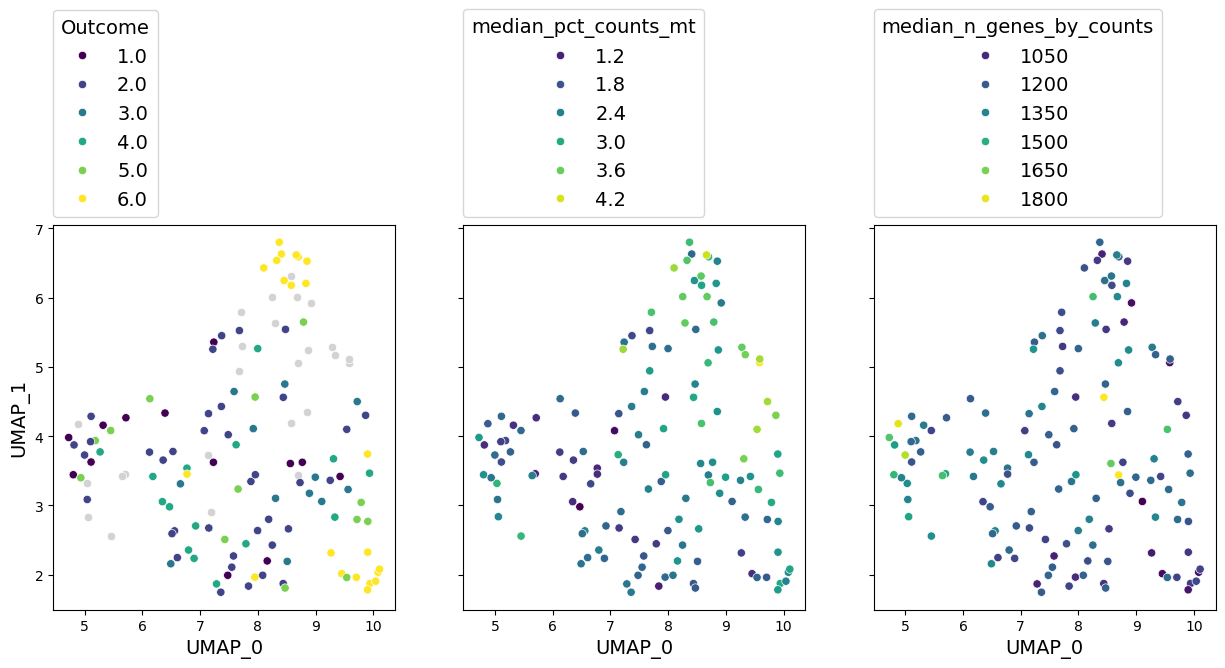

In [28]:
axes = gloscope_r.plot_embedding(method="UMAP", metadata_cols=well_represented_cols)

for ax, col in zip(axes, well_represented_cols):
    ax.legend(loc=(0, 1.02), title=col)

# Benchmarking GloScope reimplementation

Here are some more technical results on the reimplementation of GloScope for interested readers.

## How much faster is the Python reimplementation of GloScope?

**Up to 160x faster** with GPU and **up to 7x faster** without it. The bigger your dataset, the faster our implementation is. Here are the results of an experiment with COMBAT dataset subsets of a different size:

![images/gloscope_eval_speedup.png](images/gloscope_eval_speedup.png)

## How similar are the results of different GloScope implementations?

For all practical purposes, **they are identical**. Here is the comparison of KL divergence matrices obtained on a different subsets of the COMBAT dataset by different reimplementations. Mean squared error (MSE) is used to compare numerical results, and Spearman correlation is used to check whether the order of samples is preserved. Both metrics are close to their limits (0 and 1 correspondingly):

![images/gloscope_eval_matrices.png](images/gloscope_eval_matrices.png)

The GloScope reimplementation in Python was developed by [Emma Schonner](https://github.com/EmmaSchonner) as a part of her Master thesis at the Technical University of Munich (TUM)